In [1]:
import numpy as np
import pandas as pd
import os
import struct
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

## 1. Data preparation

### 1.1 Load data

In [2]:
! pip install idx2numpy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# got the dataset from http://yann.lecun.com/exdb/mnist/
import idx2numpy

train_lables_dataset = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
train_images_dataset = idx2numpy.convert_from_file('train-images-idx3-ubyte')

test_images_dataset = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
test_lables_dataset = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')


In [4]:
print(f"Training data size is {train_images_dataset.shape}\nTesting data size is {test_images_dataset.shape}")

Training data size is (60000, 28, 28)
Testing data size is (10000, 28, 28)


In [5]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [6]:
file_path = ""
X_train,y_train = load_mnist(file_path)
n, p = X_train.shape
print(n,p)

60000 784


In [7]:
X_test, y_test = load_mnist(file_path, kind='t10k')

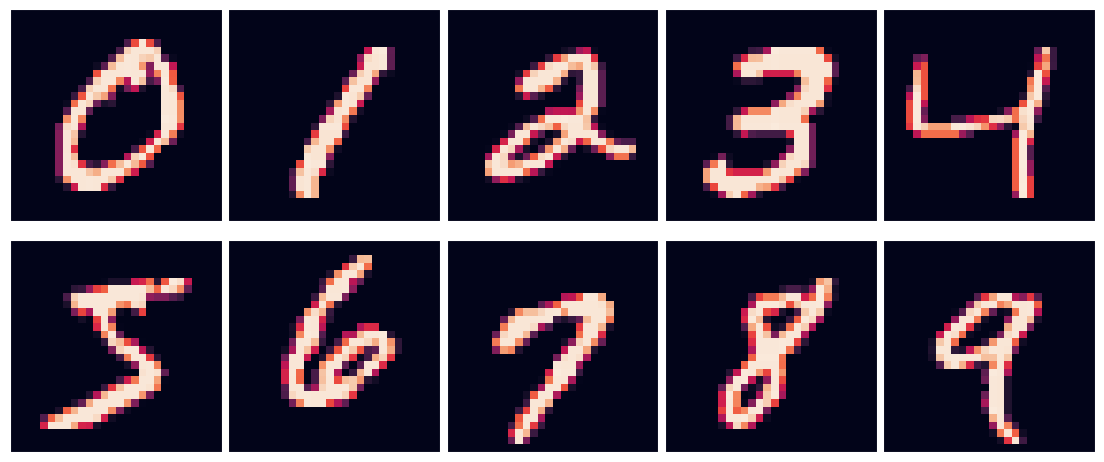

In [8]:
fig = plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.03, hspace=0.00001)
for i in range(10):
    plt.subplot(2,5,i+1)
    img = train_images_dataset[train_lables_dataset == i][0].reshape(28, 28)
    plt.imshow(img , 
              interpolation='nearest'
             )
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
x_train = deepcopy(X_train)
x_train[x_train != 0] = 255

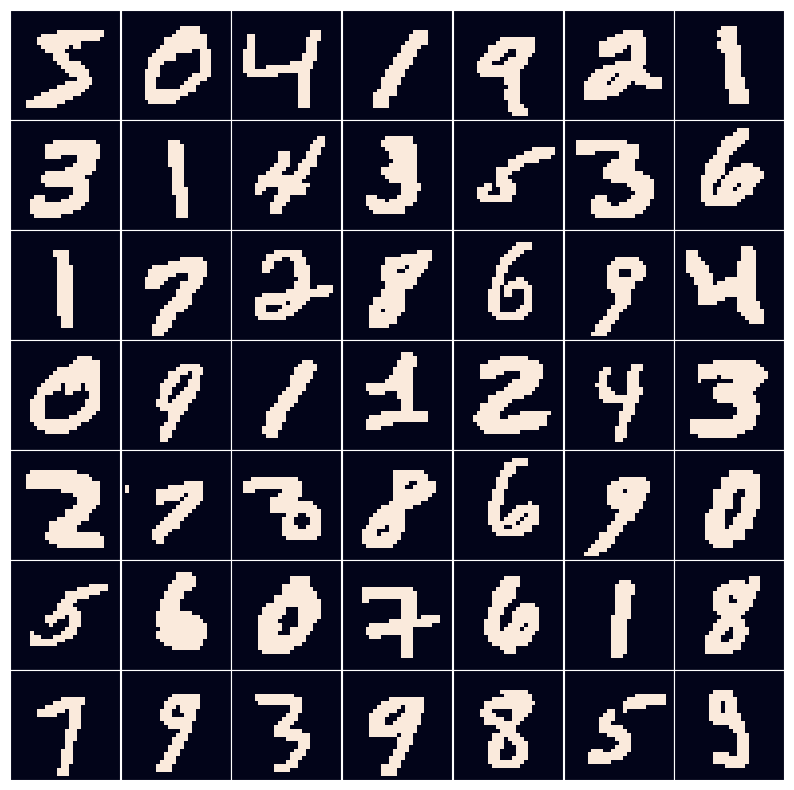

In [10]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    plt.subplot(7,7,i+1)
    img = x_train[i].reshape(28, 28)
    plt.imshow(img , 
              #cmap='Greys',
              #interpolation='nearest'
             )
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [11]:
xx_train = deepcopy(X_train)
threshold_mat = np.repeat(np.mean(xx_train, axis=1).reshape(n, 1)
                          , p, axis=1)
xx_train[xx_train <= threshold_mat] = 0
xx_train[xx_train != 0] = 255



xx_test = deepcopy(X_test)
threshold_mat = np.repeat(np.mean(xx_test, axis=1).reshape(10000, 1)
                          , p, axis=1)
xx_test[xx_test <= threshold_mat] = 0
xx_test[xx_test != 0] = 255


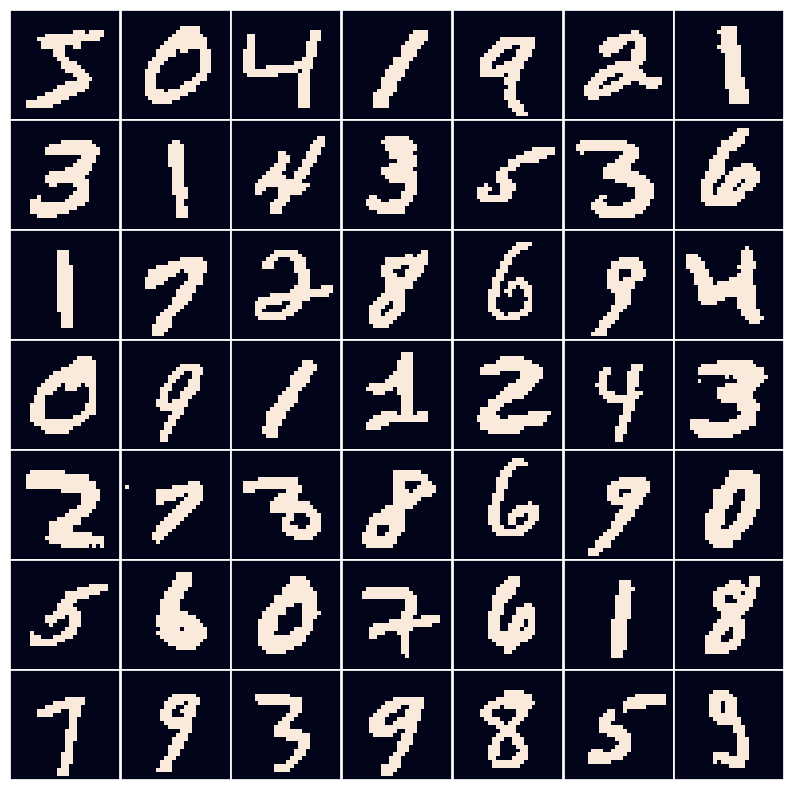

In [12]:
sns.set()
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(49):
    plt.subplot(7,7,i+1)
    img = xx_train[i].reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [13]:
def non_zero_num(data):
    return np.count_nonzero(data, axis=1)
non_zero_num(xx_train).shape

(60000,)

In [14]:
def x_tick(data, m=28):
    if np.ndim(data) == 1:
        n = 1
    n, _ = data.shape
    result = np.ravel(np.repeat(np.arange(1, m + 1).reshape(1, m),
                       repeats=m,
                       axis=0))  
    result = np.repeat(result.reshape(1, m * m),
                      repeats=n,
                      axis=0)
    result = data * result
    return np.float64(result) 

In [15]:
def x_mean(data, m=28):
    result = x_tick(data, m=m)
    result[result == 0] = np.nan 
    return np.nanmean(result, axis=1)

In [16]:
def x_std(data, m=28):
    result = x_tick(data, m=m)
    result[result == 0] = np.nan 
    return np.nanstd(result, axis=1)

In [17]:
df_temp = pd.DataFrame(np.c_[x_mean(xx_train), x_std(xx_train), np.int64(y_train)],
                       columns=['x_mean', 'x_std', 'Label'])
df_temp.head()

,x_mean,x_std,Label
0,3767.127660,1070.030197,5.0
1,3834.562500,1235.463651,0.0
2,3718.565217,1646.756069,4.0
3,3839.010989,908.361712,1.0
4,3765.500000,853.223886,9.0


In [18]:
def y_tick(data, m=28):
    if np.ndim(data) == 1:
        n = 1
    n, _ = data.shape
    result = np.repeat(np.arange(m, 0, -1).reshape(1, m),
                       repeats=m,
                       axis=1) 
    result = np.repeat(result.reshape(1, m * m),
                      repeats=n,
                      axis=0)
    result = data * result
    return np.float64(result)

In [19]:
def y_mean(data, m=28):
    result = y_tick(data, m=m)
    result[result == 0] = np.nan 
    return np.nanmean(result, axis=1)

In [20]:
def y_std(data, m=28):
    result = y_tick(data, m=m)
    result[result == 0] = np.nan 
    return np.nanstd(result, axis=1)

In [21]:
def pearson(data, m=28):
    
    n, _ = data.shape 
    
    x = x_tick(data, m=m)
    y = y_tick(data, m=m)
    
    x[x == 0.0] = np.nan
    y[y == 0.0] = np.nan
    
    c_x = x - x_mean(data).reshape(n, 1)  
    c_y = y - y_mean(data).reshape(n, 1)  
    
    p1 = np.nansum(c_x * c_y, axis=1)
    p2 = (np.nansum(c_x ** 2, axis=1) * np.nansum(c_y ** 2, axis=1)) ** 0.5  
    
    return p1 / p2

In [22]:
temp_df = pd.DataFrame(np.c_[pearson(xx_train), y_train], columns=['Pearson', 'Label'])
temp_df.Label = np.intp(temp_df.Label)
temp_df

,Pearson,Label
0,0.386401,5
1,0.399733,0
2,-0.114477,4
3,0.923105,1
4,0.002348,9
...,...,...
59995,0.573230,8
59996,0.547625,3
59997,0.389493,5
59998,0.378797,6


In [23]:
def findContoursAndBoundingRectangles(data, plot=False, m=28):
    
    global rect
    
    if np.ndim(data) == 1:
        n = 1
    else:
        n, _ = data.shape
    
    result_1 = []
    result_2 = []
    result_3 = []
    box = None
    
    for i_ in range(n):

        thresh = xx_train[i_].reshape(m, m)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            x, y, w, h = cv2.boundingRect(c)

            rect = cv2.minAreaRect(c)
            
            if plot:

                box = cv2.boxPoints(rect)

                box = np.intp(box)
                
        xy, hw, ratio = rect

        result_1.append((x, y, w, h))
        x, y = xy
        h, w = hw
        rect = [x, y, h, w, ratio]
        
        result_2.append(rect)
        result_3.append(box)
        
    return result_1, np.vstack(result_2), result_3

In [24]:
_, _, temp = findContoursAndBoundingRectangles(xx_train[:14], plot=True)
len(temp)

14

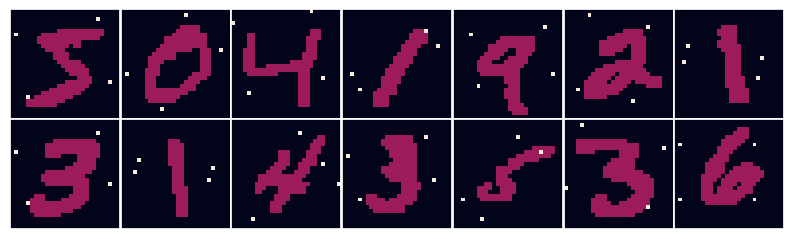

In [25]:
sns.set()
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for i in range(14):
    box = temp[i]
    img = (X_train[i].reshape(28, 28) != 0) * 100
    for j in range(4):
        x, y = tuple(box[j])
        img[x-1, y-1] = 255
    
    plt.subplot(7,7,i+1)
    plt.imshow(img)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [26]:
def left_scan(img):
    img = (img != 0)
    m, _ = img.shape
    img_move_left = np.hstack([img[:, 1:], np.zeros((m, 1))])
    result = ((img + img_move_left) == 1) * (img==0)
    num = np.sum(result != 0)
    return num, result

def right_scan(img):
    img = (img != 0)
    m, _ = img.shape
    img_move_left = np.hstack([np.zeros((m, 1)), img[:, :-1]])
    result_1 = ((img + img_move_left) == 1) * (img==0)
    result = deepcopy(result_1)
    num = np.sum(result != 0)
    return num, result

def down_scan(img):
    img = (img != 0)
    m, _ = img.shape
    img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :]])
    result = ((img + img_move_down) == 1) * (img == 0)
    num = np.sum(result != 0)
    return num, result

def up_scan(img):
    img = (img != 0)
    m, _ = img.shape
    img_move_up = np.vstack([img[1:, :] ,np.zeros((1, m))])
    result = ((img + img_move_up) == 1) * (img==0)
    num = np.sum(result != 0)
    return num, result

In [27]:
 # # Hypothetical matrix
# img = np.array([
#     [0, 1, 0, 0],
#     [1, 1, 0, 1],
#     [0, 0, 1, 1],
#     [1, 0, 1, 0]
# ])
# 
# def down_scan(img):
#     img = (img != 0)
#     m, _ = img.shape
#     img_move_down = np.vstack([np.zeros((1, m)), img[:-1, :]])
#     ans = ((img + img_move_down) == 1) * (img == 0)
#     num = np.sum(ans != 0)
#     return num, ans
# 

# num_transitions, transition_matrix = down_scan(img)
# 
# num_transitions, transition_matrix


In [28]:
def extract(data, m=28):
    
    n, _ = data.shape
    
    non_zero_num_ = non_zero_num(data) 
    
    x_mean_ = x_mean(data) 
    
    x_std_ = x_std(data) 
    
    y_mean_ = y_mean(data) 
    
    y_std_ = y_std(data) 
    
    pearson_ = pearson(data) 

    
    feature_class_1 = np.c_[x_mean_, x_std_, y_mean_, y_std_,pearson_]
    
   
    _, min_rectangle, _ = findContoursAndBoundingRectangles(data)  
    
    
    feature_class_3 = [[ right_scan(data[i_].reshape(m, m))[0], 
                         left_scan(data[i_].reshape(m, m))[0], 
                         up_scan(data[i_].reshape(m, m))[0], 
                         down_scan(data[i_].reshape(m, m))[0] ] 
                         for i_ in range(n)]     
    
    feature_class_3 = np.vstack(feature_class_3)

    return np.hstack([min_rectangle, feature_class_3])

In [29]:
train = extract(xx_train)
train.shape

(60000, 9)

In [30]:
test = extract(xx_test)
xx_test.shape

(10000, 784)

In [31]:
names = ['x', 'y', 'H', 'W', 'Theta', 'Right', 'Left', 'Up', 'Down', 'Label']

df = pd.DataFrame(data=np.hstack([train, y_train.reshape(len(y_train), 1)]), columns=names)
#df.describe()
# df.iloc[:,8]
df.head() 

,x,y,H,W,Theta,Right,Left,Up,Down,Label
0,13.500000,14.500000,15.541666,22.176054,10.619655,22.0,22.0,37.0,37.0,5.0
1,14.250002,14.250000,13.435027,21.213203,45.000000,32.0,32.0,28.0,28.0,0.0
2,11.684563,13.120806,18.189529,19.579815,10.007980,31.0,31.0,21.0,21.0,4.0
3,14.084833,14.255783,4.563181,22.968012,30.465544,20.0,20.0,14.0,14.0,1.0
4,12.865187,15.895905,12.560433,19.337227,6.709837,27.0,27.0,26.0,26.0,9.0


In [32]:
# names = ['X_mean', 'X_std', 'Y_mean', 'Y_std','Pearson','Label']
# 
# df_test = pd.DataFrame(data=np.hstack([test, y_test.reshape(len(y_test), 1)]), columns=names)
# #df.describe()
# # df.iloc[:,0]
# df_test.head() 

In [33]:
x_train_flat = train_images_dataset.reshape(train_images_dataset.shape[0], -1)

flat_column_names = [f'Pixel{i}' for i in range(x_train_flat.shape[1])]
new_column_names = flat_column_names + names

df2 = pd.DataFrame(data=np.hstack([x_train_flat, df]), columns=new_column_names)
df2.head()

,Pixel0,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,x,y,H,W,Theta,Right,Left,Up,Down,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.500000,14.500000,15.541666,22.176054,10.619655,22.0,22.0,37.0,37.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.250002,14.250000,13.435027,21.213203,45.000000,32.0,32.0,28.0,28.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.684563,13.120806,18.189529,19.579815,10.007980,31.0,31.0,21.0,21.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.084833,14.255783,4.563181,22.968012,30.465544,20.0,20.0,14.0,14.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.865187,15.895905,12.560433,19.337227,6.709837,27.0,27.0,26.0,26.0,9.0


In [34]:
# Create a KNN classifier with k=1
knn_classifier = KNeighborsClassifier(n_neighbors=1)
# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [35]:
train_dataset = df.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

##### this dataset consist of all extracted features

In [36]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.7026


##### this dataset is just flatten image 

In [37]:
train_dataset = df2.iloc[:, :784].to_numpy()
train_labels = df2.iloc[:, -1].to_numpy()

In [38]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.9727


#####  x is choosed from extracted images ; the accuracy is calculated

In [39]:
train_dataset = df.iloc[:, 0].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [40]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2007


#####  y is choosed from extracted images ; the accuracy is calculated

In [41]:
train_dataset = df.iloc[:, 1].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [42]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2600


#####  H is choosed from extracted images ; the accuracy is calculated

In [43]:
train_dataset = df.iloc[:, 2].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [44]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2408


#####  W is choosed from extracted images ; the accuracy is calculated

In [45]:
train_dataset = df.iloc[:, 3].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [46]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2502


#####  Theta is choosed from extracted images ; the accuracy is calculated

In [47]:
train_dataset = df.iloc[:, 4].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [48]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.1429


##### Right is choosed from extracted images ; the accuracy is calculated

In [49]:
train_dataset = df.iloc[:, 5].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [50]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2616


##### Left is choosed from extracted images ; the accuracy is calculated

In [51]:
train_dataset = df.iloc[:, 6].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [52]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2507


##### Up is choosed from extracted images ; the accuracy is calculated

In [53]:
train_dataset = df.iloc[:, 7].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [54]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2255


##### Down is choosed from extracted images ; the accuracy is calculated

In [55]:
train_dataset = df.iloc[:, 8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [56]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
train_dataset = train_dataset.reshape(-1, 1)
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.2285


#####  remove X from extracted features

In [57]:
train_dataset = df.drop(df.columns[0], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()


In [58]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.6504


#####  remove Y from extracted features

In [59]:
train_dataset = df.drop(df.columns[1], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [60]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}") 

Mean Accuracy: 0.6138


#####  remove H from extracted features

In [61]:
train_dataset = df.drop(df.columns[2], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [62]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.6671


#####  remove W from extracted features

In [63]:
train_dataset = df.drop(df.columns[3], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [64]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.6408


#####  remove Theta from extracted features

In [65]:
train_dataset = df.drop(df.columns[4], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [66]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.6591


#####  remove Right from extracted features

In [67]:
train_dataset = df.drop(df.columns[5], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [68]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.7025


#####  remove Left from extracted features

In [69]:
train_dataset = df.drop(df.columns[6], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [70]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.7027


#####  remove Up from extracted features

In [71]:
train_dataset = df.drop(df.columns[7], axis=1)
train_dataset = train_dataset.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [72]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.7029


#####  remove Down from extracted features

In [73]:
train_dataset = df.iloc[:, :8].to_numpy()
train_labels = df.iloc[:, -1].to_numpy()

In [74]:
# Perform cross-validation and print the accuracy for each fold
accuracy_array = []
fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_labels, cv=kf)
for fold, accuracy in enumerate(fold_accuracies, 1):
    # print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    accuracy_array.append(accuracy)
print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")

Mean Accuracy: 0.7026


##### Add Edge as a new feature

In [82]:
edge_features = np.array([cv2.Canny(train_images_dataset[i_], 100, 200).flatten()  for i_ in range(n)])

x_train_flat = train_images_dataset.reshape(train_images_dataset.shape[0], -1)

X_with_edges = np.concatenate((x_train_flat, edge_features), axis=1)


In [84]:
edge_features.shape

(60000, 784)

In [85]:
df = pd.DataFrame(data=np.hstack([edge_features, y_train.reshape(len(y_train), 1)]))
# df.head()

In [86]:
train_dataset = df.drop(df.columns[-1], axis=1)
train_labels = df.iloc[:, -1].to_numpy()

In [88]:
# # Perform cross-validation and print the accuracy for each fold
# accuracy_array = []
# fold_accuracies = cross_val_score(knn_classifier, train_dataset, train_lables_dataset, cv=kf)
# for fold, accuracy in enumerate(fold_accuracies, 1):
#     accuracy_array.append(accuracy)
# print(f"Mean Accuracy: {np.mean(accuracy_array):.4f}")
#     